In [ ]:
!wget "https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?"
!tar xvf "/content/genres.tar.gz?" -C "/content/"

In [ ]:
!pip install shutup
from google.colab import drive
drive.mount("/content/drive")

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from librosa import feature
from glob import glob
import pandas as pd
import numpy as np
import librosa
import csv
import scipy

import shutup
import os
import shutil
shutup.please()

Feature Extraction from Audio data and saving them in their respective .csv 📁 file 🔉

In [25]:
genre = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [26]:
def GenerateFeatures (path_to_file):
  audio = librosa.util.example_audio_file() 
  y,sr=librosa.load(path_to_file)

  y_harmonic, y_percussive = librosa.effects.hpss(y)
  tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)

  chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
  mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
  cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  contrast=librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zrate=librosa.feature.zero_crossing_rate(y_harmonic)

  chroma_mean=np.mean(chroma,axis=1)
  chroma_std=np.std(chroma,axis=1)
  chroma_df=pd.DataFrame()

  for i in range(0,12):
      chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
  for i in range(0,12):
      chroma_df['chroma_std_'+str(i)]=chroma_std[i]
  chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)

  mfccs_mean=np.mean(mfccs,axis=1)
  mfccs_std=np.std(mfccs,axis=1)
  mfccs_df=pd.DataFrame()
  for i in range(0,13):
      mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
  for i in range(0,13):
     mfccs_df['mfccs_std_'+str(i)]=mfccs_std[i]
  mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)

  cent_mean=np.mean(cent)
  cent_std=np.std(cent)
  cent_skew=scipy.stats.skew(cent,axis=1)[0]
  contrast_mean=np.mean(contrast,axis=1)
  contrast_std=np.std(contrast,axis=1)  

  rolloff_mean=np.mean(rolloff)
  rolloff_std=np.std(rolloff)
  rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]

  spectral_df=pd.DataFrame()
  collist=['cent_mean','cent_std','cent_skew']
  for i in range(0,7):
      collist.append('contrast_mean_'+str(i))
  for i in range(0,7):
      collist.append('contrast_std_'+str(i))
  collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
  for c in collist:
      spectral_df[c]=0
  data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
  spectral_df.loc[0]=data

  zrate_mean=np.mean(zrate)
  zrate_std=np.std(zrate)
  zrate_skew=scipy.stats.skew(zrate,axis=1)[0]

  zrate_df=pd.DataFrame()
  zrate_df['zrate_mean']=0
  zrate_df['zrate_std']=0
  zrate_df['zrate_skew']=0
  zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]

  beat_df=pd.DataFrame()
  beat_df['tempo']=tempo
  beat_df.loc[0]=tempo

  final_df=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)

  return final_df

In [27]:
GenerateFeatures('/content/genres/blues/blues.00000.au').columns

Index(['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2'

Data Genrator

In [28]:
dir = '/content/genres/'
columns = ['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_std_0', 'contrast_std_1', 'contrast_std_2',
       'contrast_std_3', 'contrast_std_4', 'contrast_std_5', 'contrast_std_6',
       'rolloff_mean', 'rolloff_std', 'rolloff_skew', 'zrate_mean',
       'zrate_std', 'zrate_skew', 'tempo']

for gen in genre:
  print (f"Current gen: {gen}")
  path = dir + gen

  files = os.listdir(path+'/')
  GenreFrame = pd.DataFrame(columns=columns)

  for clip in files:
    clip_path = dir + gen + '/' + clip

    print(f'Extracting features from {clip_path}')
    clipDataFrame = GenerateFeatures(clip_path)
    clipDataFrame['label'] = gen
  
    GenreFrame = pd.concat((GenreFrame, clipDataFrame), axis=0)

  GenreFrame.to_csv('/content/' + gen + '.csv')
  print(f'Label: {gen} saved at /content/{gen}.csv\n\n\n\n')
  shutil.copy (f"/content/{gen}.csv", f"/content/drive/MyDrive/IITK DL datasets/{gen}.csv")


Current gen: blues
Extracting features from /content/genres/blues/blues.00004.au
Extracting features from /content/genres/blues/blues.00052.au
Extracting features from /content/genres/blues/blues.00083.au
Extracting features from /content/genres/blues/blues.00011.au
Extracting features from /content/genres/blues/blues.00073.au
Extracting features from /content/genres/blues/blues.00046.au
Extracting features from /content/genres/blues/blues.00088.au
Extracting features from /content/genres/blues/blues.00090.au
Extracting features from /content/genres/blues/blues.00076.au
Extracting features from /content/genres/blues/blues.00026.au
Extracting features from /content/genres/blues/blues.00048.au
Extracting features from /content/genres/blues/blues.00086.au
Extracting features from /content/genres/blues/blues.00075.au
Extracting features from /content/genres/blues/blues.00049.au
Extracting features from /content/genres/blues/blues.00010.au
Extracting features from /content/genres/blues/blue

Reading .csv file and adding a new column type ✔

In [29]:
blues = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/blues.csv")
classical = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/classical.csv")
country = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/country.csv")
disco = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/disco.csv")
hiphop = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/hiphop.csv")
jazz = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/jazz.csv")
metal = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/metal.csv")
pop = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/pop.csv")
reggae = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/reggae.csv")
rock = pd.read_csv("/content/drive/MyDrive/IITK DL datasets/rock.csv")

blues.drop(["Unnamed: 0"], inplace=True, axis=1)
classical.drop(["Unnamed: 0"], inplace=True, axis=1)
country.drop(["Unnamed: 0"], inplace=True, axis=1)
disco.drop(["Unnamed: 0"], inplace=True, axis=1)
hiphop.drop(["Unnamed: 0"], inplace=True, axis=1)
jazz.drop(["Unnamed: 0"], inplace=True, axis=1)
metal.drop(["Unnamed: 0"], inplace=True, axis=1)
pop.drop(["Unnamed: 0"], inplace=True, axis=1)
reggae.drop(["Unnamed: 0"], inplace=True, axis=1)
rock.drop(["Unnamed: 0"], inplace=True, axis=1)

blues['label'] = 'blues'
classical['label'] = 'classical'
country['label'] = 'country'
disco['label'] = 'disco'
hiphop['label'] = 'hiphop'
jazz['label'] = 'jazz'
metal['label'] = 'metal'
pop['label'] = 'pop'
reggae['label'] = 'reggae'
rock['label'] = 'rock'

Creating The Main Dataframe for training our Model 🚩

In [30]:
genres = [blues, 
          classical, 
          country,
          hiphop, 
          jazz,
          metal, 
          pop,
          reggae,
          disco,
          rock]

final_df = pd.concat(genres)

In [31]:
final_df.columns

Index(['chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
       'mfccs_std_11', 'mfccs_std_12', 'cent_mean', 'cent_std', 'cent_skew',
       'contrast_mean_0', 'contrast_mean_1', 'contrast_mean_2'

Encoding labels of Target column ✈

In [32]:
final_df.sample(20)

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo,label
69,0.197543,0.255582,0.269635,0.195362,0.384643,0.248956,0.167442,0.232984,0.275626,0.320376,...,3.424264,3.231101,5113.935898,1227.565295,1227.565295,0.105971,0.042322,0.642499,135.999178,disco
44,0.047321,0.073755,0.094531,0.450756,0.293272,0.079767,0.039265,0.160462,0.523101,0.269207,...,2.453349,5.058617,4447.838817,1083.182591,1083.182591,0.059825,0.029386,0.291689,117.453835,metal
77,0.182425,0.146767,0.274295,0.192192,0.348417,0.304989,0.251402,0.251212,0.205192,0.212543,...,7.797924,6.603979,5088.539042,1297.302810,1297.302810,0.117901,0.050283,0.275780,95.703125,metal
65,0.337413,0.114700,0.299986,0.132721,0.145127,0.205119,0.109212,0.286428,0.154573,0.148814,...,5.188185,4.542467,3235.576104,1427.661731,1427.661731,0.087406,0.034126,1.196248,107.666016,classical
49,0.103389,0.340291,0.360046,0.296666,0.272094,0.286331,0.256062,0.224274,0.242515,0.238920,...,2.374834,1.964076,6860.793232,996.742468,996.742468,0.086850,0.038271,1.181510,123.046875,jazz
69,0.114404,0.080253,0.251254,0.421703,0.066780,0.336037,0.053651,0.346068,0.380400,0.156893,...,4.100526,4.324958,2496.202849,1026.807900,1026.807900,0.072908,0.029208,0.987436,99.384014,classical
85,0.288926,0.300111,0.166536,0.173308,0.157725,0.234491,0.295623,0.204896,0.296450,0.220924,...,2.621409,2.235584,5862.414551,1252.865270,1252.865270,0.114732,0.055430,0.336077,135.999178,rock
35,0.229278,0.253820,0.098445,0.208848,0.322551,0.214866,0.377856,0.199263,0.255840,0.194226,...,3.448509,2.540226,5304.662123,735.406114,735.406114,0.122807,0.028581,0.618468,103.359375,metal
27,0.296765,0.103350,0.154193,0.243425,0.202661,0.272880,0.202402,0.404764,0.261854,0.091009,...,3.161930,2.453504,3375.924959,1511.749839,1511.749839,0.038175,0.019475,0.998706,135.999178,jazz
42,0.236703,0.181214,0.253930,0.109769,0.207825,0.125602,0.201388,0.284894,0.231220,0.398973,...,2.499506,1.586759,5986.680118,1643.658548,1643.658548,0.082889,0.023542,0.433662,107.666016,pop


In [33]:
import seaborn as sns

corr = final_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_std_0,chroma_std_1,chroma_std_2,chroma_std_3,chroma_std_4,chroma_std_5,chroma_std_6,chroma_std_7,chroma_std_8,chroma_std_9,chroma_std_10,chroma_std_11,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,cent_mean,cent_std,cent_skew,contrast_mean_0,contrast_mean_1,contrast_mean_2,contrast_mean_3,contrast_mean_4,contrast_mean_5,contrast_mean_6,contrast_std_0,contrast_std_1,contrast_std_2,contrast_std_3,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
chroma_mean_0,1.000000,0.114236,0.002162,-0.164430,-0.263424,0.176601,-0.353210,0.084088,-0.282845,-0.239025,0.032479,0.093570,0.464142,-0.098762,0.007861,-0.063601,-0.149807,0.360307,-0.254695,0.137085,-0.157116,-0.165469,0.074311,-0.131134,-0.014789,0.026150,-0.030904,-0.059227,-0.049519,-0.078324,-0.013601,-0.068486,0.011279,-0.065430,0.020874,-0.023143,0.041236,0.028569,-0.006183,0.027768,-0.053319,-0.042344,-0.049853,-0.073890,-0.031769,-0.034774,-0.016735,0.049037,0.022150,0.023178,-0.022408,-0.057413,-0.019330,-0.048126,-0.032793,0.031275,0.036082,0.055127,0.070300,-0.048671,-0.002739,-0.069001,-0.029556,0.011555,0.033140,0.036106,-0.012198,-0.026140,-0.028686,-0.028686,0.038121,-0.048636,-0.075492,-0.012224
chroma_mean_1,0.114236,1.000000,0.205524,0.161898,-0.095752,-0.201442,0.099823,-0.349551,0.101590,-0.142284,-0.053553,0.090732,-0.248046,0.409923,-0.192248,-0.012184,-0.189045,-0.268774,0.169384,-0.274227,-0.021524,-0.224647,-0.200700,-0.047569,0.104117,-0.147663,0.043416,0.070593,0.000493,0.092432,0.069875,0.131078,0.067710,0.130452,0.090004,0.160982,0.074846,-0.114856,-0.034565,-0.041638,-0.076986,-0.083408,-0.057594,-0.049832,-0.090837,-0.122442,-0.122041,-0.120946,-0.157459,-0.158776,0.155063,0.074289,-0.078577,-0.013259,-0.225643,-0.225532,-0.253852,-0.248793,-0.223521,0.004431,0.008216,-0.035839,-0.028784,-0.053548,-0.152927,-0.179686,-0.123982,0.158429,0.049892,0.049892,0.077024,0.076310,0.039368,0.010159
chroma_mean_2,0.002162,0.205524,1.000000,0.123466,-0.034009,-0.205033,-0.104535,0.097925,-0.386461,-0.035408,-0.243771,-0.098557,0.028013,-0.113598,0.414303,-0.071135,-0.045954,-0.145428,-0.080513,0.294329,-0.240508,0.006436,-0.178290,-0.041882,0.024667,0.006672,-0.081563,-0.024648,-0.094675,-0.023399,-0.081575,-0.009580,-0.092997,-0.003613,-0.032520,0.011417,-0.041022,-0.003126,0.024113,-0.045360,-0.009626,-0.031054,-0.036300,0.021275,-0.042017,-0.037974,-0.024123,-0.042947,-0.006750,0.017071,0.032382,-0.017126,-0.030872,0.017248,-0.079110,-0.026038,-0.008956,0.006175,0.024398,0.045874,0.049123,-0.018451,-0.059170,-0.048276,-0.053054,-0.020124,0.066572,0.026079,-0.038774,-0.038774,0.071223,0.020162,-0.048093,0.010355
chroma_mean_3,-0.164430,0.161898,0.123466,1.000000,0.108512,0.079686,0.000340,-0.205759,0.135923,-0.362348,0.173307,-0.166111,-0.237404,0.054424,-0.228857,0.482212,-0.246835,-0.135416,-0.054508,-0.231974,0.229268,-0.337886,0.038726,-0.165246,0.125390,-0.116175,-0.004852,0.095999,-0.089943,0.130772,-0.051325,0.138017,-0.028109,0.127005,-0.048063,0.121515,-0.051345,-0.102257,-0.071507,-0.066925,-0.085021,-0.075062,-0.042593,-0.016774,-0.071310,-0.137802,-0.120184,-0.141164,-0.131322,-0.164084,0.117328,0.015104,-0.049138,-0.031459,-0.245507,-0.216263,-0.232544,-0.215340,-0.181641,0.086867,0.047877,-0.072019,-0.028494,-0.048642,-0.123061,-0.120304,-0.050475,0.125886,-0.011988,-0.011988,0.086519,0.099495,0.035235,0.014123
chroma_mean_4,-0.263424,-0.095752,-0.034009,0.108512,1.000000,0.133779,0.176884,-0.172269,-0.147756,0.146557,-0.3696

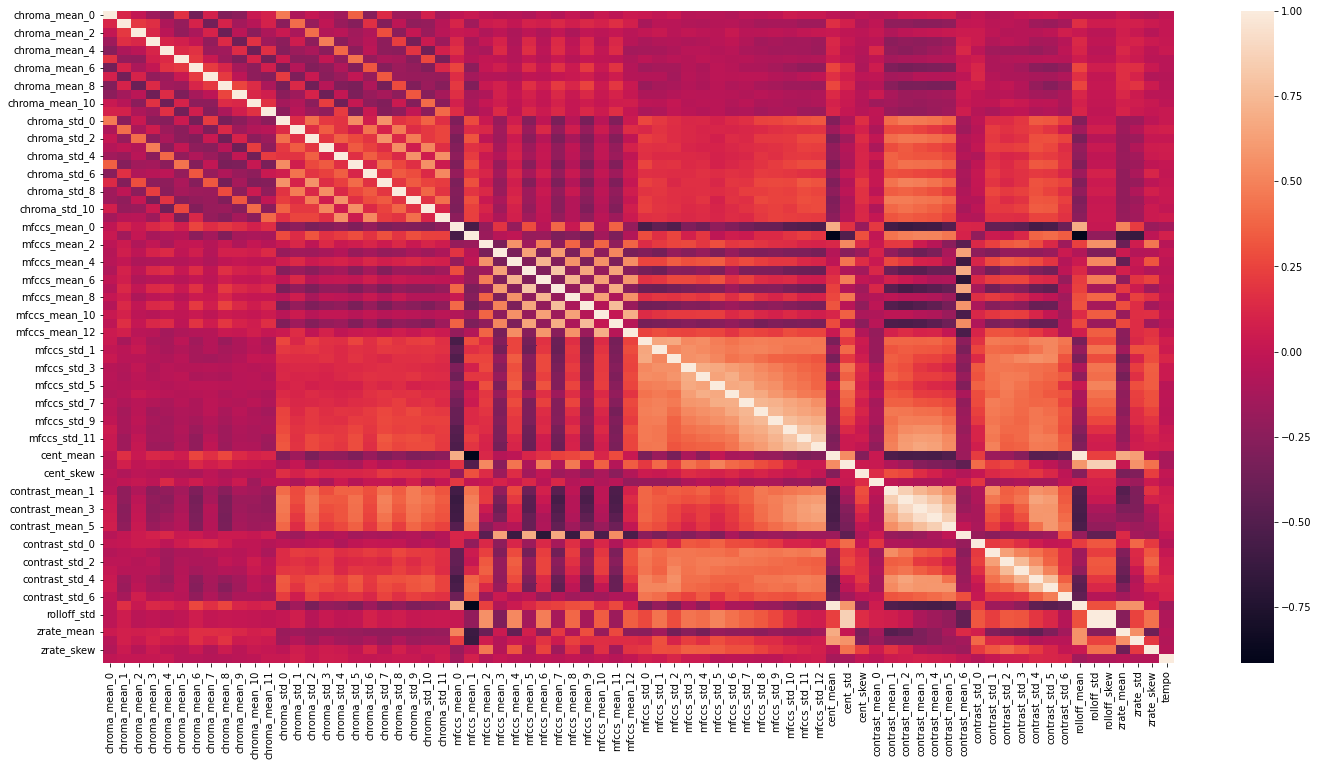

In [34]:
import seaborn as sns

f = plt.figure()
f.set_figwidth(24)
f.set_figheight(12)
sns.heatmap(final_df.corr())
plt.savefig("Plotting_Correlation_HeatMap.jpg")

Encoding Labels of Target variable ⚓

In [35]:
convertor = LabelEncoder()
class_list = final_df.iloc[:,-1]
y = convertor.fit_transform(class_list)

Fitting Rest of the columns in StanderdScaler (Using fit_transform for that)

In [36]:
fit = StandardScaler()
X = fit.fit_transform(np.array(final_df.iloc[:,:-1], dtype = float))

In [37]:
X

array([[-0.78758103,  1.31323972, -0.02422623, ..., -0.05156569,
         1.94592555,  0.47692732],
       [ 0.57309111, -0.80533541, -0.61864804, ...,  1.04513389,
         0.78150493,  0.23777061],
       [ 0.54005379, -0.24741588, -1.02514323, ..., -0.17185192,
        -0.98864913,  0.47692732],
       ...,
       [-1.42573149,  1.65683806, -0.26914176, ..., -0.67145386,
        -2.10271389, -0.17531825],
       [ 1.74439109, -0.01471305, -0.10507824, ..., -0.78648759,
         0.6447692 , -0.35492211],
       [-1.06903341, -0.58039926,  0.53618221, ...,  1.22962506,
         0.02905935, -0.35492211]])

Splitting Our Dataset for Training (x_train & y_train) and Testing (y_train & y_test)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y ,test_size=0.1)

Creating TrainModel Function for training our RNN model.

In [39]:
def trainModel (model, epochs, optimizer, verbose):
  batch_size = 128

  model.compile(optimizer,
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

  return model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=epochs, batch_size=batch_size, verbose=verbose)

Our Sequential Model ⚖

In [48]:
model = keras.models.Sequential([
                             keras.layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
                             keras.layers.Dropout(0.2),

                             keras.layers.Dense(256, activation='relu'),
                             keras.layers.Dropout(0.2),

                             keras.layers.Dense(128, activation='relu'),
                             keras.layers.Dropout(0.2),

                             keras.layers.Dense(64, activation='relu'),
                             keras.layers.Dropout(0.2),

                             keras.layers.Flatten(),
                             keras.layers.Dense(10, activation='softmax')
                          ])
print(model.summary())
model_history = trainModel(model=model, epochs=50, optimizer='adam', verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               38400     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

Summary of Model ✉

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               38400     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

Model evaluation (Increase test size to get better evaluation ✅

In [50]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128)
print (f"\nThe test loss is : {round(test_loss, 2)}")
print(f"The best test accuracy is : {round(test_acc*100, 2)}%")

1/1 [==============================] - 0s 21ms/step - loss: 1.0483 - accuracy: 0.7500

The test loss is : 1.05
The best test accuracy is : 75.0%


Preparing data for pridiction ☕

In [51]:
def makeAudio_to_Data (path):

  newDataframe = GenerateFeatures (path)
  nextDataframe = GenerateFeatures ('/content/genres/disco/disco.00000.au')

  numpyArray = fit.fit_transform(np.array(pd.concat([newDataframe, nextDataframe], axis=0), dtype=float))

  return numpyArray, newDataframe

Calling makeAudio_to_Data function

In [54]:
frame, data = makeAudio_to_Data ("/content/genres/blues/blues.00001.au")

Predicting

In [55]:
arr = model.predict(frame)
lis = arr.tolist()
print(genre[lis[0].index(max(lis[0]))].capitalize())

Blues


In [46]:
data.sample()

,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,0.298391,0.239644,0.282745,0.200693,0.136922,0.355245,0.323364,0.24725,0.165014,0.228327,...,6.105826,5.602013,4.601369,2410.827778,1333.896432,1333.896432,0.055701,0.030833,0.748121,135.999178
